# **Facial Swapping via Landmark Detection with Dlib**

1. Face swapping by detecting facial landmarks, aligning faces, warping images, and blending colors.


## Features

Facial Landmark Detection

- Uses dlib.get_frontal_face_detector() to detect faces.
- Uses dlib.shape_predictor() to extract 68 facial landmarks for feature alignment.

Image Processing & Alignment

- Reads two images and extracts landmarks.
- Computes an affine transformation matrix (M) to align faces.
- Warps the second face to match the first face using cv2.warpAffine().

Face Mask & Blending

- Generates a mask for blending facial features.
- Applies Gaussian blur to smooth transitions between faces.
- Uses correct_colours() to adjust color tones for seamless blending.

Face Swap Execution

- Combines the warped face with the original using the computed mask.
- Saves and displays the morphed image (output.jpg).

### Concept of Mask

Creating a Blank Mask

- A black image (same size as the input image) is initialized.
- The facial region is extracted using the detected landmarks (eyes, nose, mouth, eyebrows).

Defining the Face Region
- The code uses cv2.convexHull() to create a convex boundary around key facial features.
- cv2.fillConvexPoly() fills this region with white (1.0) to represent the face.

Blurring for a Natural Blend
- The mask is blurred using cv2.GaussianBlur() to soften the edges, preventing harsh transitions.

Combining the Masks
- A mask is created for both faces (source & destination).
- The two masks are merged to ensure a gradual blend between the images.

Applying the Mask
- The masked portion of the second face is overlaid on the first face.
- The blending ensures that the swapped face looks natural without visible edges.

Importance of Mask
- Prevents harsh edges in face swapping.
- Ensures smooth transitions between skin tones and facial features.
- Focuses only on the facial area, avoiding unnecessary blending with the background.

In [43]:
# Imports and imshow function
import cv2
import numpy as np
from matplotlib import pyplot as plt
import cv2
import dlib
import numpy
import sys

def imshow(title = "Image", image = None, size = 6):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [44]:
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1
FEATHER_AMOUNT = 11   # smoothness of blending

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [45]:
class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

In [46]:
def get_landmarks(im):
    rects = detector(im, 1)

    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im

def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:

        sum ||s*R*p1,i + T - p2,i||^2

    is minimized.

    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)

    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         numpy.matrix([0., 0., 1.])])

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

In [ ]:
# Input images here
image1_path = "image1.jpg"
image2_path = "image2.jpg"

im1, landmarks1 = read_im_and_landmarks(image1_path)
im2, landmarks2 = read_im_and_landmarks(image2_path)

M = transformation_from_points(landmarks1[ALIGN_POINTS],
                               landmarks2[ALIGN_POINTS])

mask = get_face_mask(im2, landmarks2)
warped_mask = warp_im(mask, M, im1.shape)
combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                          axis=0)

warped_im2 = warp_im(im2, M, im1.shape)
warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

cv2.imwrite('combined.jpg', output_im)

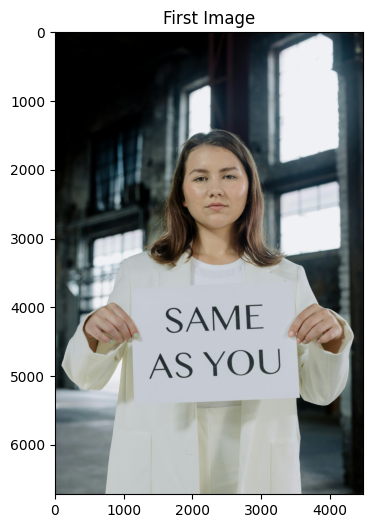

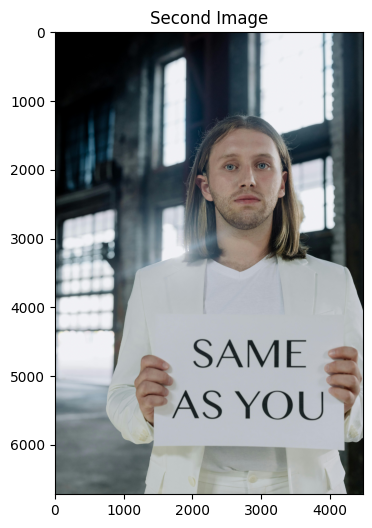

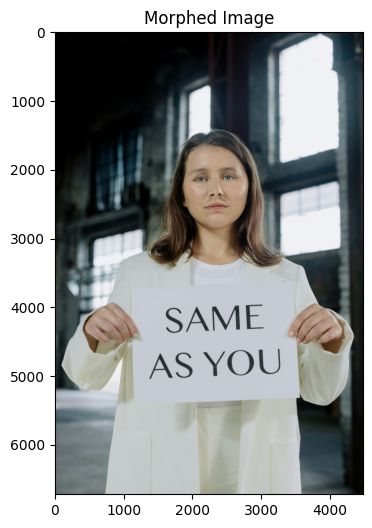

In [42]:
image1 = cv2.imread('image1.jpg')
image2 = cv2.imread('image2.jpg')
combined_image = cv2.imread("output.jpg")

imshow('First Image',image1)
imshow('Second Image',image2)
imshow('Morphed Image',combined_image)

In [ ]:
#!/usr/bin/python

# Copyright (c) 2015 Matthew Earl
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
#     The above copyright notice and this permission notice shall be included
#     in all copies or substantial portions of the Software.
#
#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS
#     OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
#     MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN
#     NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM,
#     DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
#     OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE
#     USE OR OTHER DEALINGS IN THE SOFTWARE.